# Table of Contents
1. [Travelling salesman](#1)
    1. [Write down the Markov matrix](#1a)
    2. [For every simulation of ech initial level, compute the total number of sold carpets and plot the probability mass density](#1b)
    3. [For each different initial level, compute the average number of carpets and plot it as a function of the initial level](#1c)
    4. [For each different initial level, plot the PMFs for time required for the saleman to sell 5 carpets](1d)
    5. [For each different initial level, compute the average time it takes to sell 5 carpets and plot it as a function of the initial level](1e)
    6. [Plot the probability of selling less than 5 carpets as a functoin of the initial level](1f)
    7. [Why does the current process produce these functional form?](1g)
2. [Possion process for radioactive decay](#2)
    1. [Simulate radioactive decay by both methods](#2a)
    2. [b) Determine the mean and variance for $𝑡_{1/2}$ by averaging over 100 simulations](#2b)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from typing import List
import time
import math
import random

# 1. Travelling salesman<a name='1'></a>
We assume
1. the salesman has 10 levels of excitement;
2. excitement transition rule: for each interaction,
    - sold - increase by 1 level
    - rejected - decrease by 1 level; 
3. probabilities to sell a carpet *depending on how the salesman feels*: $\{0, 0.1, 0.2, \ldots 0.9\}$
## a) Write down the Markov matrix <a name='1a'></a>
$$
\mathbf{P} = \left[\begin{array}{cc}
1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ 
0.9 & 0.0 & 0.1 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ 
0.0 & 0.8 & 0.0 & 0.2 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ 
0.0 & 0.0 & 0.7 & 0.0 & 0.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0\\ 
0.0 & 0.0 & 0.0 & 0.6 & 0.0 & 0.4 & 0.0 & 0.0 & 0.0 & 0.0\\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.5 & 0.0 & 0.5 & 0.0 & 0.0 & 0.0\\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.4 & 0.0 & 0.6 & 0.0 & 0.0\\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.3 & 0.0 & 0.7 & 0.0\\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.2 & 0.0 & 0.8\\ 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.1 & 0.9\\ 
\end{array}\right]_{10 \times 10}
$$

In [2]:
class Saleman:
    def __init__(self, 
                 num_levels: int=10, 
                 probs: List=np.linspace(0, 0.9, 10)):
        """Markov chain example: travelling saleman 
        Attrs:
        ------
        num_levels: int 
            the number of excitement level, then the excitement level range will be [0, self.num_levels-1]
        probs: List[float]
            the probabilities to successfully sell a carpet depending on excitement levels
        """
        if not isinstance(probs, (float, list, np.ndarray)):
            raise ValueError('`probs` should either be float or array of length `num_levels`.')
                
        if isinstance(probs, float):
            probs = [probs for _ in range(num_levels)]
        elif num_levels != len(probs):
            raise ValueError('`probs` should either be float or array of length `num_levels`.')
                                 
        self.num_levels = num_levels
        self.probs = probs
            
    def init_markov_matrix(self):
        """initialize markov matrix.
        NOTE: not necessary for Markov chain simulation. just for testing.
        """
        P = list()
        # for the bottom level
        row_0 = [0.0 for _ in range(self.num_levels)]
        row_0[0] = 1.0
        P.append(row_0)
        # for the intermediate levels
        for i in range(1, self.num_levels-1):
            row = [0.0 for _ in range(self.num_levels)]
            row[i+1] = self.probs[i]
            row[i-1] = 1-self.probs[i]
            P.append(row)
            
        # for the top level
        row_t = [0.0 for _ in range(self.num_levels)]
        row_t[-1] = self.probs[-1]
        row_t[-2] = 1-self.probs[-2]
        P.append(row_t)
        markov_matrix = np.array(P, dtype=float)
        return markov_matrix
    
    def required_time_simulate(self, target_num: int=5, time_period: int=1000, num_simulations: int=10000):
        """simulation for 
        1) the required time of selling at least `target_num` of carpets
        2) the probability of selling less than `target_num` of carpets
        with different initial levels, except for the first level, since no carpets can be sold.
        """
        LOWEST_LEVEL, HIGHEST_LEVEL = 0, 9
        
        st = time.time()
        
        simulation_matrix = list() # number of initial levels \times number of successful runs, required time to sell at least ... carpets
        fail_probabilities = list() # (number of initial levels), probabilities of not selling at least...
        for level in range(1, self.num_levels): 
            # NOTE the level range: [1, 9]
            print(f'with initial level={level}:')
            level_simulation = list()
            num_success = 0 
            for _ in range(num_simulations):
                current_level = level
                num_carpets = 0
                for timestep in range(time_period):
                    # check if reaching target
                    if num_carpets >= target_num:
                        level_simulation.append(timestep)
                        num_success += 1 
                        break
                    
                    if current_level > LOWEST_LEVEL: # save runtime: the saleman will not sell any more carpets when he have reached the lowest.
                        rand = np.random.random() 
                        if rand >= 1-self.probs[current_level]:
                            num_carpets += 1 
                            current_level = min(current_level+1, HIGHEST_LEVEL)
                        else: 
                            current_level -= 1
                            
            if len(level_simulation) > 0: 
                print(f'Average required time: {sum(level_simulation)/len(level_simulation): .2f} timesteps.') 
            else: 
                level_simulation = list()
                print(f'None of the simulations meet the target.')  
            simulation_matrix.append(level_simulation)
            level_fail_p = 1-num_success/num_simulations
            print(f'probabilities of failing to meet target: {level_fail_p: .2f}.') 
            fail_probabilities.append(level_fail_p)
            
        et = time.time()
        print(f'Simulation time: {et-st: .4f}s')
        return simulation_matrix, fail_probabilities
        
    def num_carpets_simulate(self, time_period: int=1000, num_simulations: int=1):
        """simulation for the total number of sold carpets, with different initial levels.
        NOTE that the saleman will not be able to sell any carpets when the initial level is 0. So, no need to simulate for the first level.
        
        Args:
        -----
        time_period: int 
            the time period over which the simulations for each inital level are run.
        num_simualtions: int 
            the number of simulations for each initial level.
        Returns:
        --------
        simulation_matrix: List[List[int]], num_level x num_simulations
            the simulated total number of carpets for each simulation with different initial levels of excitement. 
            
        """
        LOWEST_LEVEL, HIGHEST_LEVEL = 0, 9
        
        st = time.time()
        
        simulation_matrix = list()
        
        for level in range(1, self.num_levels): 
            # NOTE the level range: [1, 9]
            print(f'with initial level={level}:')
            level_simulation = list()
            for _ in range(num_simulations):
                current_level = level
                num_carpets = 0
                for _ in range(time_period):
                    if current_level > LOWEST_LEVEL: # save runtime: the saleman will not sell any more carpets when he have reached the lowest.
                        rand = np.random.random() 
                        if rand >= 1-self.probs[current_level]:
                            num_carpets += 1 
                            current_level = min(current_level+1, HIGHEST_LEVEL)
                        else: 
                            current_level -= 1
                level_simulation.append(num_carpets)
            print(f'Average number of carpets: {int(sum(level_simulation)/num_simulations)}')  
            
            simulation_matrix.append(level_simulation)
            
        et = time.time()
        print(f'Simulation time: {et-st: .4f}s')
        return simulation_matrix


# initialization 
num_simulations = 10000
saleman = Saleman()
saleman.init_markov_matrix()

array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.9, 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.8, 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.7, 0. , 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0.6, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0.7, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0.8],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.9]])

In [3]:
def pmf(DATA,log_binning=False, log_x=False, log_y=False, plot_mid=False, axs=None):
    """probability mass function given by histograms and midpoints.
    Args: 
    ----
    log_binning: boolean
        whether to use linear binning or logarithmic binning.
    log_x, log_y: boolean 
        whether to use linear or logarithmic coordinate.
    plot_mid: boolean
        whether to use midpoints of bins.
    """
    if axs == None: 
        fig, axs = plt.subplots(1, 1)
        
    #START_VALUE, STOP_VALUE = min(DATA), np.ceil(max(DATA) / 100).astype(int) * 100 # STOP_VALUE: round up to nearest k*100 
    NUMBER_OF_BINS = 20
    
    START_VALUE, STOP_VALUE = min(DATA), max(DATA)
    # binning 
    if log_binning:
        bins = np.logspace(start=np.log10(START_VALUE), stop=np.log10(STOP_VALUE), num=NUMBER_OF_BINS) # logarithmic binning
    else: 
        bins = np.linspace(start=START_VALUE, stop=STOP_VALUE, num=NUMBER_OF_BINS) # linear binning
        # bins = np.linspace(start=START_VALUE, stop=STOP_VALUE, num=NUMBER_OF_BINS) # linear binning
        # logarithmic coordinates (for both x and y!)
    if log_x:
        axs.set_xscale('log')
    if log_y:    
        axs.set_yscale('log')
        
    if plot_mid:
    # midpoints
        # determine the midpoints of the bins and plot the binned data values at these midpoints.
        values, edges = np.histogram(DATA, bins=bins, density=True)
        centers = 0.5*(edges[1:] + edges[:-1])
        axs.plot(centers, values, '*')
    
    # histogram
    values, edges, _ = axs.hist(DATA, bins=bins, density=True, color='lightblue')

## b) For every simulation of ech initial level, compute the total number of sold carpets and plot the probability mass density<a name='1b'></a>

In [4]:
num_simulation_matrix = saleman.num_carpets_simulate(num_simulations=num_simulations)

with initial level=1:
Average number of carpets: 0
with initial level=2:
Average number of carpets: 9
with initial level=3:
Average number of carpets: 43
with initial level=4:
Average number of carpets: 123
with initial level=5:
Average number of carpets: 228
with initial level=6:
Average number of carpets: 346
with initial level=7:
Average number of carpets: 422
with initial level=8:
Average number of carpets: 449
with initial level=9:
Average number of carpets: 457
Simulation time:  20.1820s


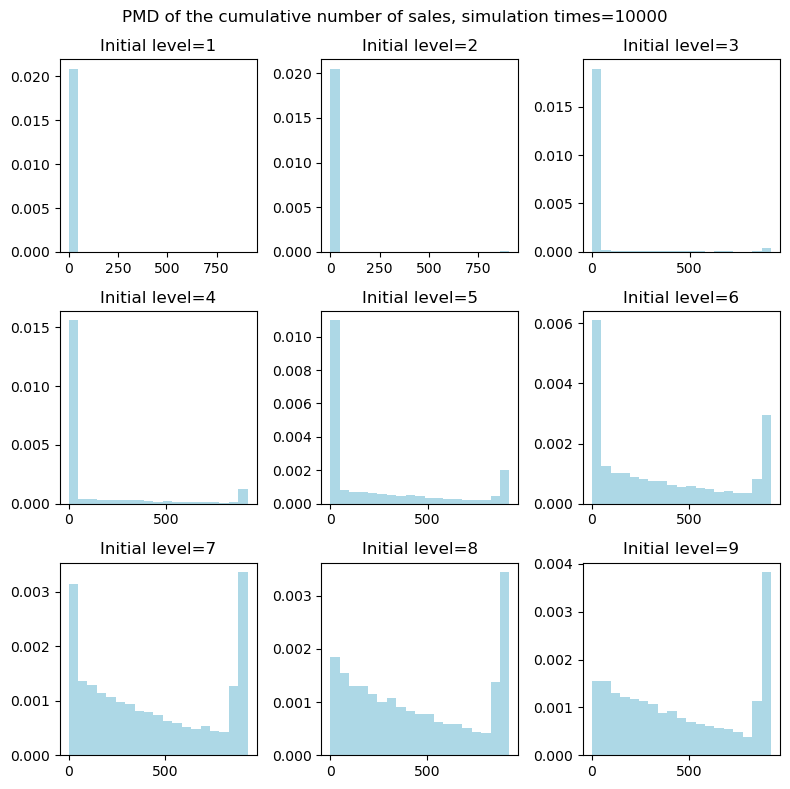

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = np.ravel(axs)
fig.suptitle(f'PMD of the cumulative number of sales, simulation times={num_simulations}')
for i, a in enumerate(axs):
    a.set_title(f'Initial level={i+1}')
    pmf(num_simulation_matrix[i], axs=a)
    
fig.tight_layout()

## c) For each different initial level, compute the average number of carpets and plot it as a function of the initial level<a name='1c'></a>

Text(0, 0.5, 'average number of carpets')

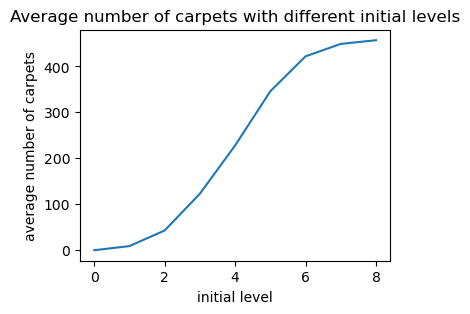

In [6]:
num_levels, num_simulations = len(num_simulation_matrix), len(num_simulation_matrix[0])
average_num_carpets = [int(sum(sm)/num_simulations) for sm in num_simulation_matrix] 

fig, axs = plt.subplots(1, figsize=(4, 3))
axs.plot([*range(num_levels)], average_num_carpets, '-')
axs.set_title('Average number of carpets with different initial levels')
axs.set_xlabel('initial level')
axs.set_ylabel('average number of carpets')

## d) For each different initial level, plot the PMFs for time required for the saleman to sell 5 carpets.<a name='1d'></a>
(we exclue the runs that ended up without selling at least 5 carpets)

The PMFs for each different initial level is shown below, and it seems to have exponential or power-law form. To determine, we additionally plot the PMFs for sufficiently high initial level = $7, 8, 9$ with 1) linear binnings and logarithmic y-axis, 2) logarithmic binning and coordinates.

A more clear *linear fitting* can be observed when using linear binnings and logarithmic y-axis. This indicates that the PMFs probably follows a **exponential-form**. 

Refers to question g) for more explanation.

In [7]:
required_t_simulation_matrix, fail_probabilities = saleman.required_time_simulate()

with initial level=1:
Average required time:  6.35 timesteps.
probabilities of failing to meet target:  0.99.
with initial level=2:
Average required time:  6.68 timesteps.
probabilities of failing to meet target:  0.97.
with initial level=3:
Average required time:  6.98 timesteps.
probabilities of failing to meet target:  0.87.
with initial level=4:
Average required time:  7.06 timesteps.
probabilities of failing to meet target:  0.68.
with initial level=5:
Average required time:  6.92 timesteps.
probabilities of failing to meet target:  0.43.
with initial level=6:
Average required time:  6.58 timesteps.
probabilities of failing to meet target:  0.22.
with initial level=7:
Average required time:  6.21 timesteps.
probabilities of failing to meet target:  0.07.
with initial level=8:
Average required time:  5.83 timesteps.
probabilities of failing to meet target:  0.02.
with initial level=9:
Average required time:  5.64 timesteps.
probabilities of failing to meet target:  0.00.
Simulation

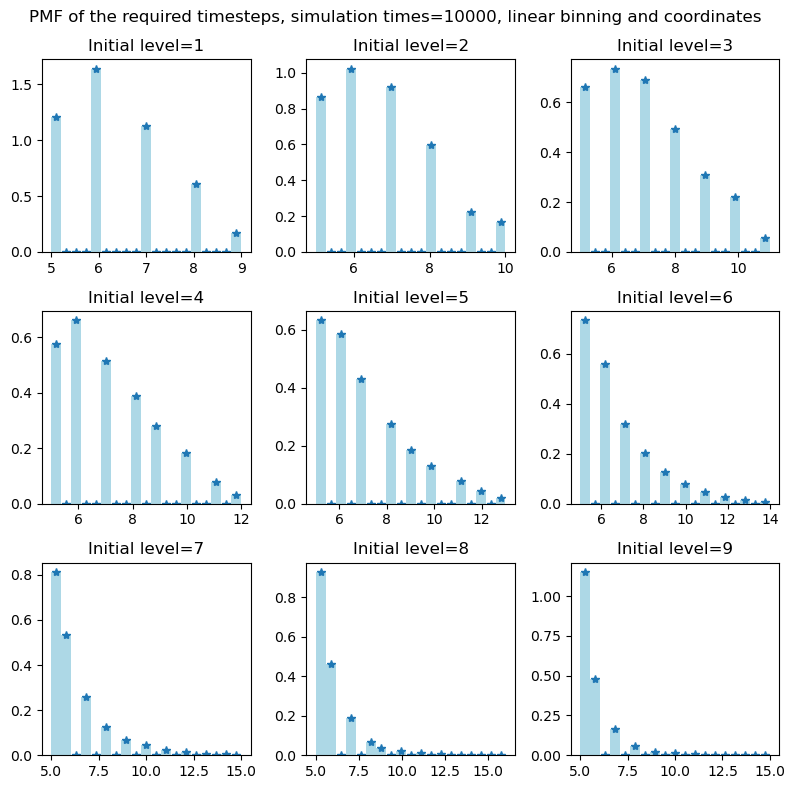

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = np.ravel(axs)
fig.suptitle(f'PMF of the required timesteps, simulation times={num_simulations}, linear binning and coordinates')
for i, a in enumerate(axs):
    a.set_title(f'Initial level={i+1}')
    pmf(required_t_simulation_matrix[i], plot_mid=True, axs=a)
    
fig.tight_layout()

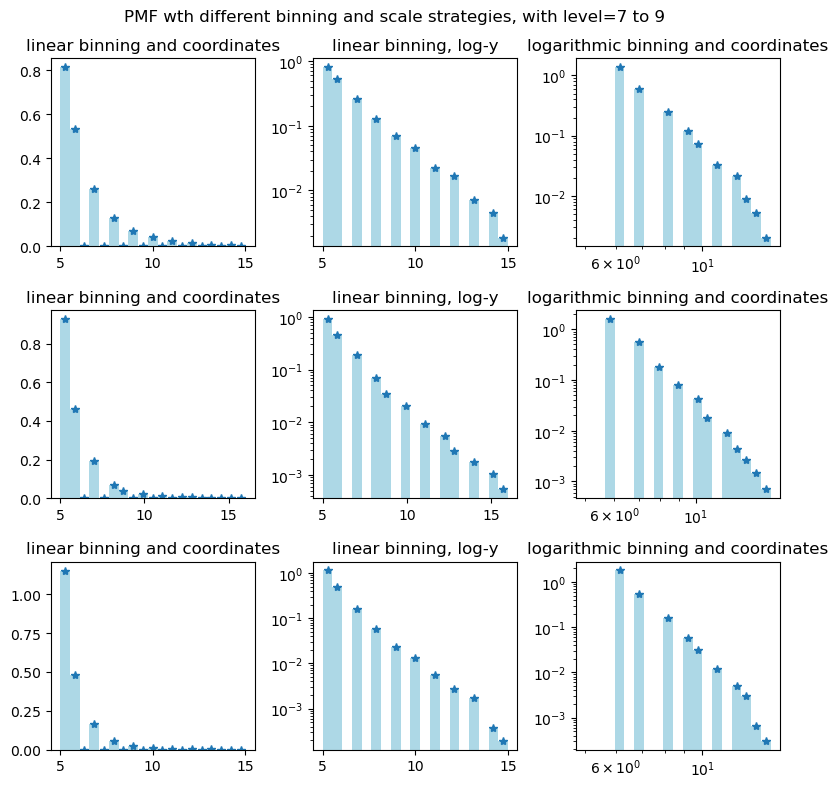

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle(f'PMF wth different binning and scale strategies, with level=7 to 9')
for i in range(3):
    axs[i][0].set_title(f'linear binning and coordinates')
    # linear binning, linear coordinates
    pmf(required_t_simulation_matrix[i+6], plot_mid=True, axs=axs[i][0])
    
    # linear binning, logarithmic y-axis -> exponential
    axs[i][1].set_title(f'linear binning, log-y')
    pmf(required_t_simulation_matrix[i+6], plot_mid=True, log_y=True, axs=axs[i][1])
    
    # logarithmic binning, logarithmic coordinates -> power-law
    axs[i][2].set_title(f'logarithmic binning and coordinates')
    pmf(required_t_simulation_matrix[i+6], plot_mid=True, log_binning=True, log_x=True, log_y=True, axs=axs[i][2])

fig.tight_layout()

## e) For each different initial level, compute the average time it takes to sell 5 carpets and plot it as a function of the initial level<a name='1e'></a>
*Notes to myself*: Poisson. [Binomial distribution, given the number of success, what is the expected total number of trials?](https://math.stackexchange.com/questions/1378801/binomial-distribution-given-the-number-of-success-what-is-the-expected-total-n)

Intuitively: excluding runs that didn't sell enough carpets is underestimating the number of steps needed to sell 5 carpets, especially for low intial level settings.

Text(0, 0.5, 'average time/timesteps')

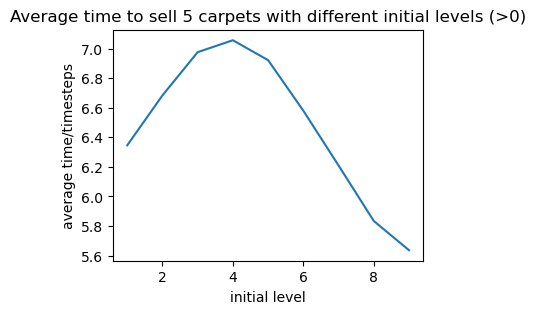

In [10]:
num_levels, num_simulations = len(required_t_simulation_matrix), len(required_t_simulation_matrix[0])
average_required_time = [sum(sm)/len(sm) for sm in required_t_simulation_matrix] 

fig, axs = plt.subplots(1, figsize=(4, 3))
axs.plot([*range(1, num_levels+1)], average_required_time, '-')
axs.set_title('Average time to sell 5 carpets with different initial levels (>0)')
axs.set_xlabel('initial level')
axs.set_ylabel('average time/timesteps')

## f)  Plot the probability of selling less than 5 carpets as a functoin of the initial level.<a name='1f'></a>

Text(0, 0.5, 'probabilities')

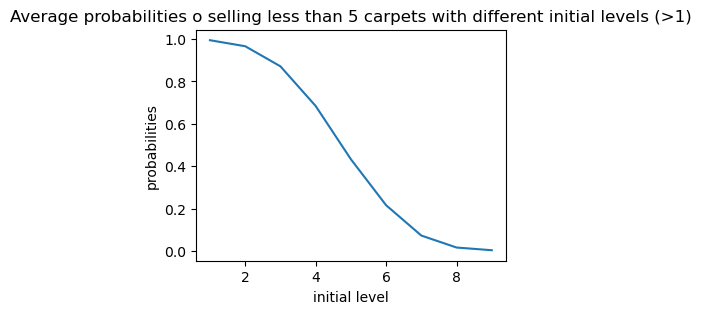

In [11]:
fig, axs = plt.subplots(1, figsize=(4, 3))
axs.plot([*range(1, num_levels+1)], fail_probabilities, '-')
axs.set_title('Average probabilities o selling less than 5 carpets with different initial levels (>1)')
axs.set_xlabel('initial level')
axs.set_ylabel('probabilities')

## g)  Why does the current process produce these functional form?<a name='1g'></a>
In question d), the PMFs we plot turn out to have a exponential form for certain levels of initial excitement. This distribution we estimated is $P(N=n|X=5)$, where $n$ is the variant.

This is because: when the initial level is sufficiently high, the saleman mostly maintains highly excited, and **the model degrades to Binomial $X \sim B(n, p)$**, where $X$ is the total number of carpets we sold, $n$ is the number of trips, $p$ is the successful probability at the initial level. 

The marginal distribution of $X$
$$
\begin{aligned}
P(X=k) &= \sum_{n=k}^\infty P(X=k|N=n) P(N=n)\\
&= e^{-p\lambda}\frac{(p\lambda)^k}{k!}, 
\end{aligned}
$$
where $k=5$ in our case. The marginal distribution of $X$ is Poisson with parameter $p\lambda$. Consequently
$$
\begin{aligned}
P(N=n|X=k) &= e^{-(1-p)\lambda}\frac{((1-p)\lambda)^{n-k}}{(n-k)!}
\end{aligned}
$$
which is a **location-transformed Poisson**. Thus that we have the logarithmic-form.

*Reference*: 

[Binomial distribution, given the number of success, what is the expected total number of trials?](https://math.stackexchange.com/questions/1378801/binomial-distribution-given-the-number-of-success-what-is-the-expected-total-n)

# 2. Possion process for radioactive decay<a name='2'></a>
We take the Poisson process to describe radioactive decay (time). 

Here we have initial number of nuclei $N_0 = 10000$ and decay rate $\lambda = 0.2$, and the samllest time interval $\Delta = 0.01$s.

## a) Simulate radioactive decay by both methods.<a name='2a'></a>
we use homogeneous Poisson process, where the decay event of an atom happens at a point randomly.

**Derivation**: 
By definition, we have $P_X(t) = \lambda e^{-\lambda t}$. Then CDF

$$
\begin{aligned}
CDF &= F_X(t) = P(X \le t)\\
&= \int ^t_0 \lambda e^{-\lambda t}dx = 1 - e^{-\lambda t}
\end{aligned}
$$
where $P(X \le t)$ is the probability to decay in time $t$ for each nuclei.
### method 1: statistician view 

**Receipt**:
1. Initialize the process at time zero $X_0 = t_0$, 
2. then <span style='color:red'>simulate $t_k \sim e^\lambda$</span> and put $X_k = X_{k-1} + t_k$, where $t_k$ is the time from the $k-1$ to the $k$th event.</br>
use inverse distribution method to generate inter-event time $t$
3. Repeat step 1 and 2 until half of nuclei have decayed, i.e. $k=N_0/2$.

**Key point: inhomogeneous Poisson proess**:
1. the decay probability for an *ensemble* of nuclei decrease with decreasing $N$, 
2. $\frac{dN(t)}{dt} = -\lambda N(t)$,
3. thus that $\lambda_{eff}(t) = \lambda{N(t)}$, and $t\sim Exp(\lambda_{eff}(t))$

Simulation time:  0.39s


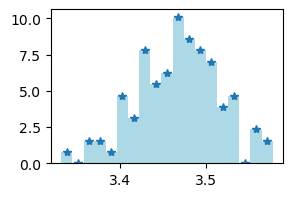

In [36]:
def statistician_simulation(N0 = 10000, decay_rate=0.2, interval=0.01, num_simulations=100):
    N_half = int(N0/2)
    half_times = list()
    
    st = time.time()
    for _ in range(num_simulations):
        half_t = np.sum(np.asarray([np.random.exponential(1/decay_rate/(N0 - n)) for n in range(N_half)]))
        half_times.append(half_t)
    
    et = time.time()
    print(f'Simulation time: {et-st: .2f}s')
    return half_times

sta_simulation = statistician_simulation()
fig, axs = plt.subplots(1, figsize=(3,2))

pmf(sta_simulation, plot_mid=True, axs=axs)

### method 2: physicist view
Simulating the stochastic process in time steps; per time step $\Delta t=0.01$s.

**Receipt**:
1. specify the time interval $\Delta = 0.01$, 
2. make trials for the event and <span style='color: red'>accept with probability $P(X \le t)$</span>
3. increase time by $\Delta$ after each attempt, 
4. repeat step 2 and 3 until half of nuclei have decayed.

**Key points: $P(X \le t)$**

Simulation time:  97.36s


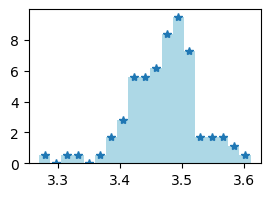

In [37]:
def physicist_simulation(num_simulations=100, N0 = 10000, decay_rate=0.2, interval=0.01):
    """https://timeseriesreasoning.com/contents/poisson-process/"""
    half_time_list = list() 
    st = time.time()
    half_N0 = int(N0/2)
    for _ in range(num_simulations):
        current_num = 0 # total decay nuclei
        half_time = 0
        while current_num < half_N0: 
            half_time += interval 
            not_decay_rate = math.exp(-decay_rate*interval) # the probability not to decay 
            for _ in range(N0 - current_num): # rest nuclei
                rand = np.random.random()
                if rand > not_decay_rate:
                    current_num += 1
        half_time_list.append(half_time)
    et = time.time()
    print(f'Simulation time: {et-st: .2f}s')
    return half_time_list
    
phy_simulation = physicist_simulation()
fig, axs = plt.subplots(1, figsize=(3,2))
pmf(phy_simulation, plot_mid=True, axs=axs)

## b) Determine the mean and variance for $t_{1/2}$ by averaging over 100 simulations <a name='2b'></a>

In [14]:
def mean_and_variance(DATA):
    mean = sum(DATA)/len(DATA)
    variance = sum((d - mean) ** 2 for d in DATA) / len(DATA)
    return mean,variance

### method 1: statistician view 


In [22]:
sta_mean, sta_var = mean_and_variance(sta_simulation)
print(f'[Statistician way] mean: {sta_mean: .6f}s, variance: {sta_var: .6f}s')

[Statistician way] mean:  3.466169s, variance:  0.002203s


### method 2: physician view 



In [17]:
phy_mean, phy_var = mean_and_variance(phy_simulation)
print(f'[physician way] mean: {phy_mean: .6f}s, variance: {phy_var: .6f}s')

[physician way] mean:  3.479300s, variance:  0.001947s


### verification with $N(t)= N_0 e^{-\lambda t}$
With this equation, we can directly obatin $t_{1/2}$ 
$$
\begin{aligned}
\frac{1}{2} N_0 &= N_0 e^{-\lambda t}\\
t &= \log{2} / \lambda
\end{aligned}
$$

In [1]:
def closed_form_calculation(decay_rate=0.2):
    return math.log(2) / decay_rate 

half_t = closed_form_calculation()
print(f'[analytical] mean: {half_t: .6f}s')

NameError: name 'math' is not defined